## Import library

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as st 
import pyodbc as odbc
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Connect to MSSQL SERVER

In [6]:
import pyodbc
from sqlalchemy import create_engine

server = r'.\SQLEXPRESS'
database = 'Momo_project'

connection_string = (
    "mssql+pyodbc://@"
    f"{server}/{database}"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)

engine = create_engine(connection_string)


## Descriptive Statistics

In [9]:
#!pip install ipython-sql
%load_ext sql


c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:1636: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


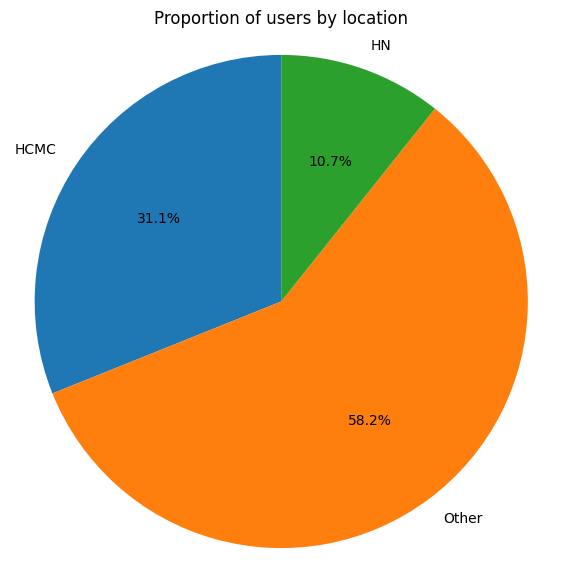

In [12]:
query = """
SELECT
    location,
    COUNT(*) * 100.0 / (SELECT COUNT(*) FROM users WHERE location <> 'None') AS percentage
FROM users
WHERE location <> 'None'
GROUP BY location
"""
location_pie = pd.read_sql(query, connection_string)
location_pie
plt.figure(figsize=(7,7))
plt.pie(
    location_pie["percentage"],
    labels=location_pie["location"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Proportion of users by location")
plt.axis("equal")
plt.show()


c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:1636: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


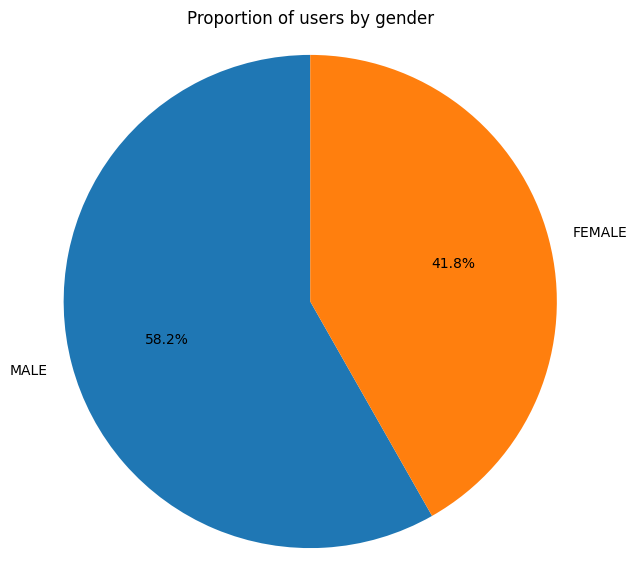

In [14]:
query_gender = """
SELECT
    gender,
    COUNT(*) * 100.0 / (SELECT COUNT(*) FROM users) AS percentage
FROM users
GROUP BY gender
"""
gender_pie = pd.read_sql(query_gender, connection_string)
gender_pie
plt.figure(figsize=(7,7))
plt.pie(
    gender_pie["percentage"],
    labels=gender_pie["gender"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Proportion of users by gender")
plt.axis("equal")
plt.show()


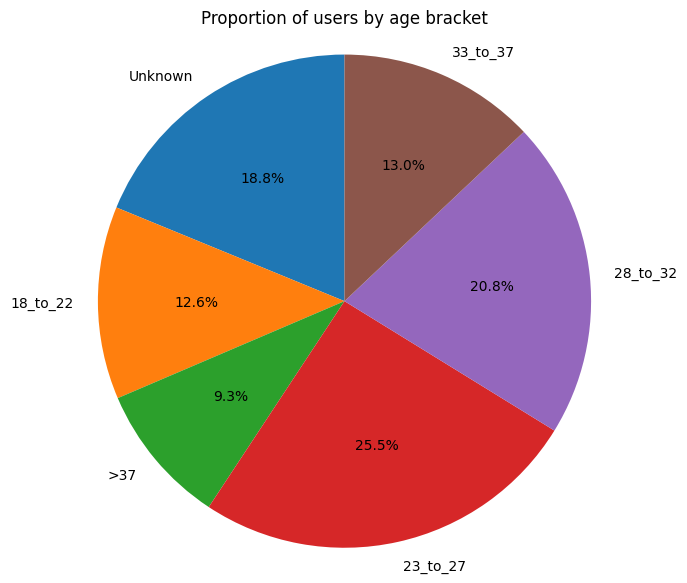

In [15]:
query_age = """
SELECT
    age,
    COUNT(*) * 100.0 / (SELECT COUNT(*) FROM users WHERE age <> 'None') AS percentage
FROM users
WHERE age <> 'None'
GROUP BY age
"""
age_pie = pd.read_sql(query_age, connection_string)
age_pie
plt.figure(figsize=(7,7))
plt.pie(
    age_pie["percentage"],
    labels=age_pie["age"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Proportion of users by age bracket")
plt.axis("equal")
plt.show()


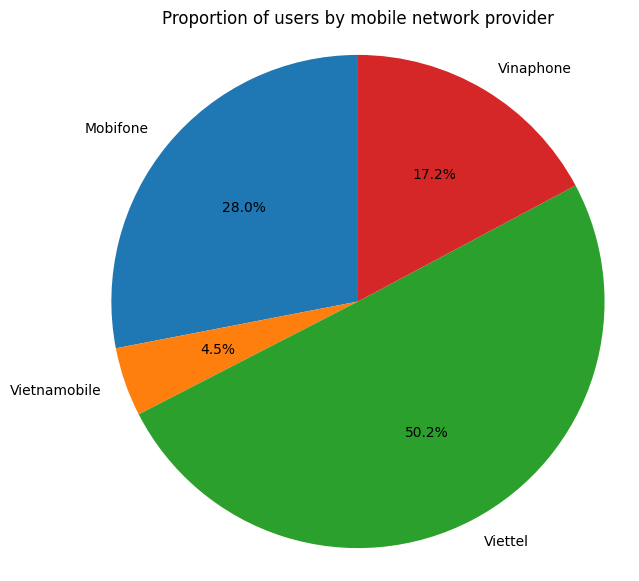

In [16]:
query_merchant = """
SELECT
    c.merchant_name,
    COUNT(*) * 100.0 / (
        SELECT COUNT(*)
        FROM transactions t2
        JOIN commission c2 ON t2.merchant_id = c2.merchant_id
        WHERE c2.merchant_name <> 'Gmobile'
    ) AS percentage
FROM transactions t
JOIN commission c ON t.merchant_id = c.merchant_id
WHERE c.merchant_name <> 'Gmobile'
GROUP BY c.merchant_name
"""
merchant_pie = pd.read_sql(query_merchant, connection_string)
merchant_pie
plt.figure(figsize=(7,7))
plt.pie(
    merchant_pie["percentage"],
    labels=merchant_pie["merchant_name"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Proportion of users by mobile network provider")
plt.axis("equal")
plt.show()


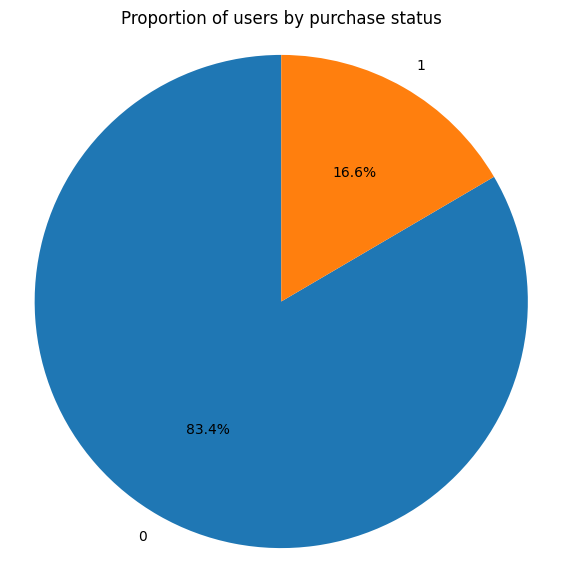

In [17]:
query_status = """
SELECT
    purchase_status,
    COUNT(*) * 100.0 / (SELECT COUNT(*) FROM transactions) AS percentage
FROM transactions
GROUP BY purchase_status
"""
status_pie = pd.read_sql(query_status, connection_string)
status_pie
plt.figure(figsize=(7,7))
plt.pie(
    status_pie["percentage"],
    labels=status_pie["purchase_status"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Proportion of users by purchase status")
plt.axis("equal")
plt.show()


In [20]:
query_amount_desc = """
WITH descriptive_stats AS (
    SELECT
        MIN(amount) AS min_amount,
        AVG(amount) AS mean_amount,
        MAX(amount) AS max_amount,
        STDEV(amount) AS standard_deviation
    FROM transactions
),
percentiles AS (
    SELECT TOP 1
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY amount) OVER () AS second_quartile,
        PERCENTILE_CONT(0.5)  WITHIN GROUP (ORDER BY amount) OVER () AS median,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY amount) OVER () AS third_quartile
    FROM transactions
)
SELECT
    min_amount,
    CAST(second_quartile AS INT) AS second_quartile,
    CAST(median AS INT)         AS median,
    mean_amount,
    CAST(third_quartile AS INT) AS third_quartile,
    max_amount,
    standard_deviation
FROM descriptive_stats
CROSS JOIN percentiles;
"""
amount_descriptive = pd.read_sql(query_amount_desc, connection_string)
amount_descriptive



c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:1636: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


,min_amount,second_quartile,median,mean_amount,third_quartile,max_amount,standard_deviation
0,10000,20000,30000,51471,50000,2500000,73315.346766


`75%` transactions are below 50.000 dong.

c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:1636: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())
c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Confidence Interval 95%: (50234.15542167926, 52708.30237750562)


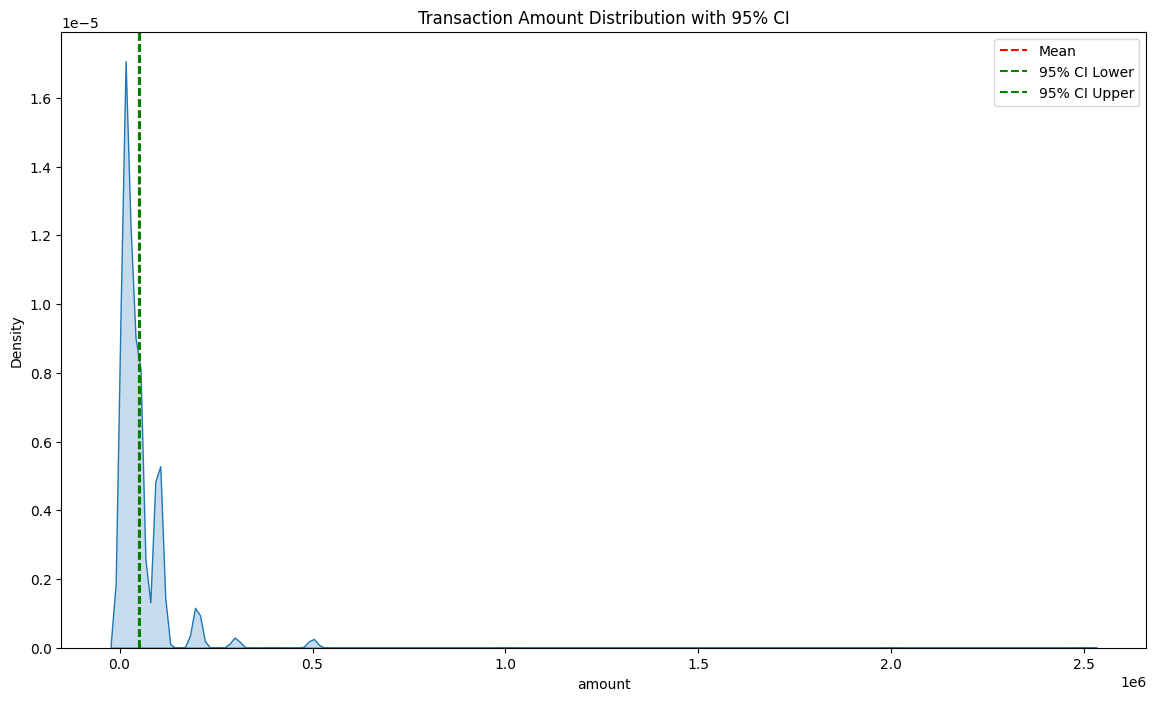

In [23]:
query_transactions = "SELECT amount FROM transactions"
transactions = pd.read_sql(query_transactions, connection_string)
transactions.head()
confidence_interval = st.t.interval(
    confidence=0.95,
    df=len(transactions["amount"]) - 1,
    loc=np.mean(transactions["amount"]),
    scale=st.sem(transactions["amount"])
)

print("Confidence Interval 95%:", confidence_interval)

mean_amount = transactions["amount"].mean()

plt.figure(figsize=(14,8))
sns.kdeplot(transactions["amount"], fill=True)

plt.axvline(mean_amount, color="red", linestyle="--", label="Mean")
plt.axvline(confidence_interval[0], color="green", linestyle="--", label="95% CI Lower")
plt.axvline(confidence_interval[1], color="green", linestyle="--", label="95% CI Upper")

plt.title("Transaction Amount Distribution with 95% CI")
plt.legend()
plt.show()


The transactions are mainly low-valued transaction.
95% of transaction value are around 50.000 dong.

## Detailed Analysis

c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:1636: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


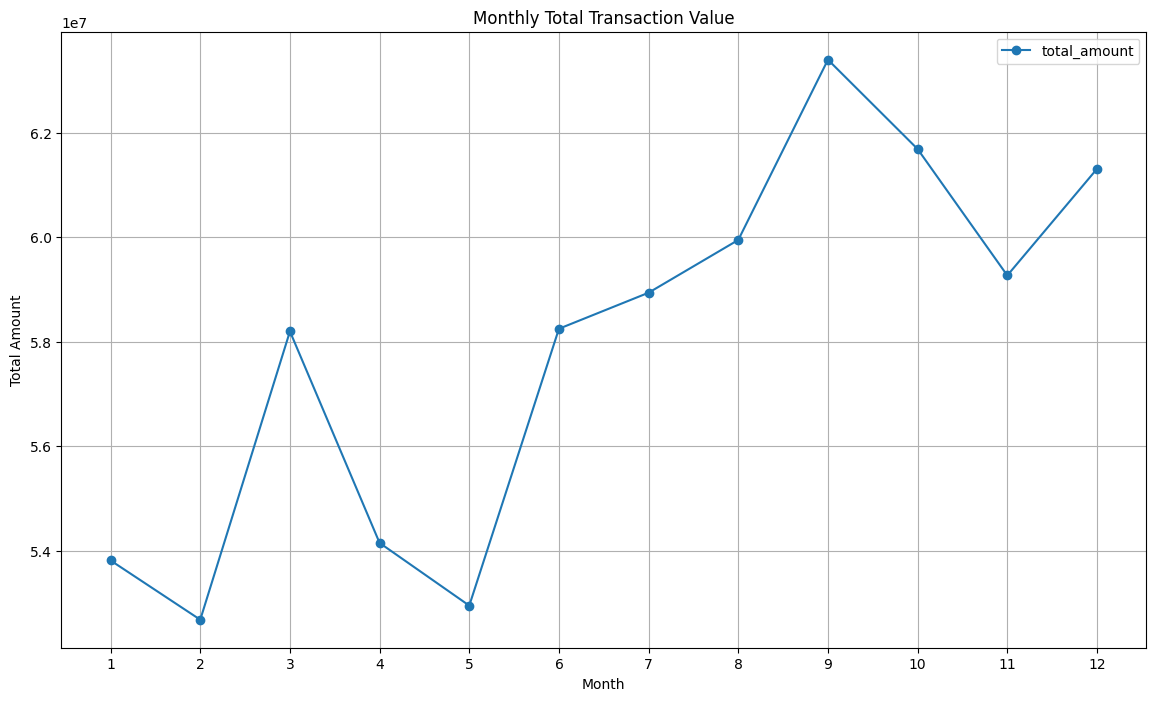

In [26]:
query_monthly = """
SELECT
    MONTH([Date]) AS month_num,
    SUM(amount) AS total_amount
FROM transactions
GROUP BY MONTH([Date])
ORDER BY month_num
"""
monthly_amount = pd.read_sql(query_monthly, connection_string)

monthly_amount.set_index("month_num").plot(
    kind="line",
    figsize=(14,8),
    marker="o"
)

plt.xticks(ticks=range(1,13))
plt.xlabel("Month")
plt.ylabel("Total Amount")
plt.title("Monthly Total Transaction Value")
plt.grid(True)
plt.show()


High season for phone account recharging is two last quarter of the year

c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:1636: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


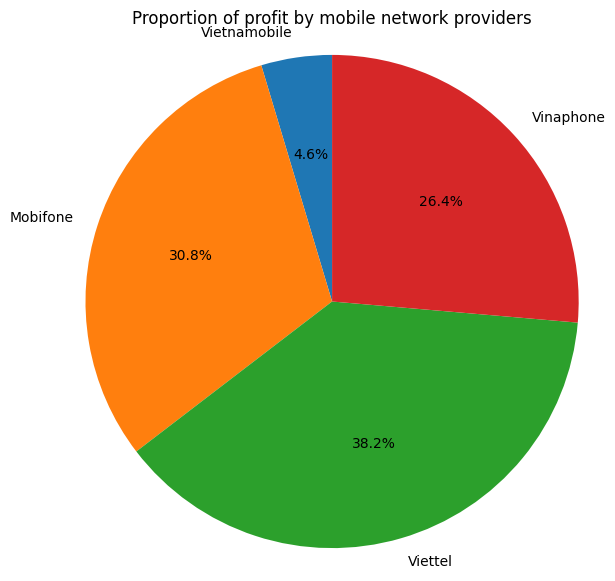

In [27]:
query_profit_merchant = """
SELECT
    c.merchant_name,
    SUM(t.amount * c.rate_pct) AS profit
FROM transactions t
JOIN commission c ON t.merchant_id = c.merchant_id
WHERE c.merchant_name <> 'Gmobile'
GROUP BY c.merchant_name
"""
profit_gain_merchant = pd.read_sql(query_profit_merchant, connection_string)
profit_gain_merchant
plt.figure(figsize=(7,7))
plt.pie(
    profit_gain_merchant["profit"],
    labels=profit_gain_merchant["merchant_name"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Proportion of profit by mobile network providers")
plt.axis("equal")
plt.show()


c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:1636: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


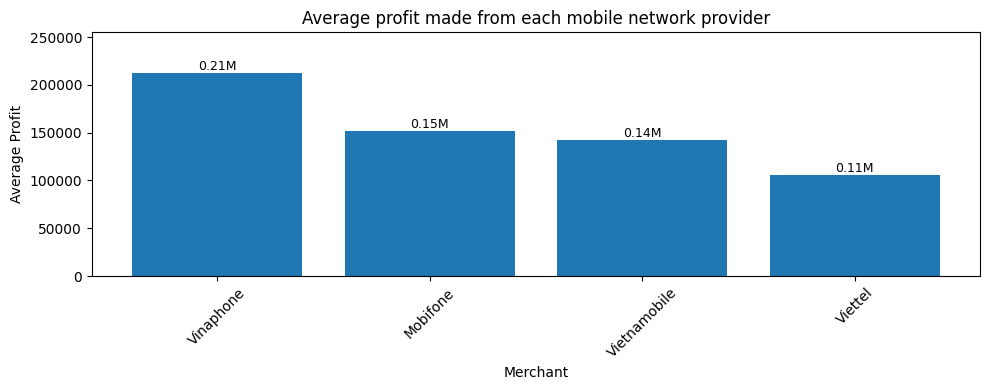

In [33]:
query_avg_profit = """
SELECT
    c.merchant_name,
    SUM(t.amount * c.rate_pct) * 1.0 / COUNT(*) AS avg_profit
FROM transactions t
JOIN commission c ON t.merchant_id = c.merchant_id
WHERE c.merchant_name <> 'Gmobile'
GROUP BY c.merchant_name
ORDER BY avg_profit DESC
"""
avg_profit_gain = pd.read_sql(query_avg_profit, connection_string)
avg_profit_gain

fig, ax = plt.subplots(figsize=(10,4))
y_max = avg_profit_gain["avg_profit"].max()
ax.set_ylim(0, y_max * 1.2)   # tăng 20% chiều cao


bars = ax.bar(
    avg_profit_gain["merchant_name"],
    avg_profit_gain["avg_profit"]
)

ax.set_title("Average profit made from each mobile network provider")
ax.set_xlabel("Merchant")
ax.set_ylabel("Average Profit")

plt.xticks(rotation=45)

# 🔥 THÊM SỐ LIỆU TRÊN CỘT
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height/1e6:.2f}M",   # format triệu
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()



## Retention rate Analysis

In [38]:
def get_new_customers(month, year, conn):
    query = """
    EXEC usp_new_cus @month = ?, @year = ?
    """
    return pd.read_sql(query, conn, params=(month, year))

new_cus_2020 = {}

for m in range(1, 13):
    new_cus_2020[m] = get_new_customers(m, 2020, connection_string)

df_new_cus_2020 = []

for m, df in new_cus_2020.items():
    temp = df.copy()
    df_new_cus_2020.append(temp)

new_cus = pd.concat(df_new_cus_2020, ignore_index=True)
new_cus

c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:1636: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


,month_year,new_customer
0,2020-01,603
1,2020-02,668
2,2020-03,617
3,2020-04,476
4,2020-05,377
5,2020-06,304
6,2020-07,311
7,2020-08,294
8,2020-09,234
9,2020-10,207


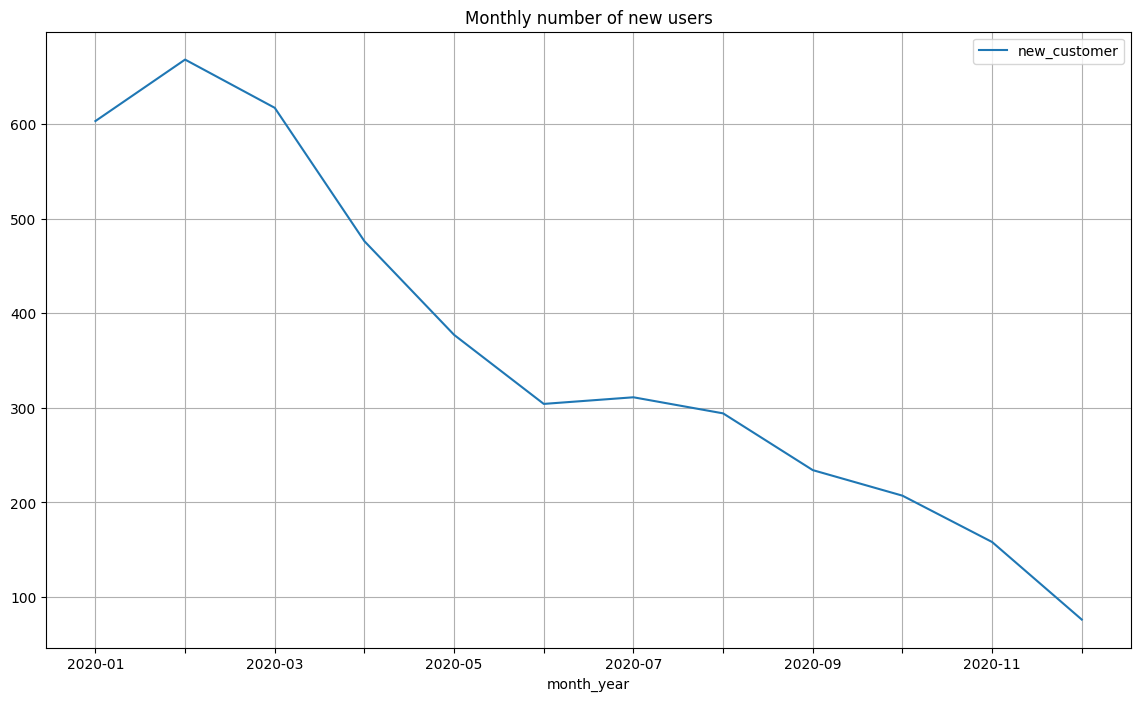

In [39]:
new_cus.set_index('month_year').plot(kind='line',figsize=(14,8))
plt.xticks(ticks=new_cus.index)
plt.title('Monthly number of new users')
plt.grid(True)

The number of new customer decrease gradually from the beginning of the year 2020 to the end of the year 2020.

In [43]:
query_repeat_users = """
SELECT COUNT(*) AS num_users
FROM (
    SELECT
        t.user_id,
        COUNT(*) AS num_order
    FROM transactions t
    LEFT JOIN users u ON t.user_id = u.user_id
    WHERE
        YEAR(first_tran_date) = 2020
        AND t.[Date] BETWEEN first_tran_date
                          AND DATEADD(MONTH, 1, first_tran_date)
    GROUP BY t.user_id
    HAVING COUNT(*) > 1
) t
"""
repeat_users_2020 = pd.read_sql(query_repeat_users, connection_string)
repeat_users_2020
num_repeat_users_m = repeat_users_2020.loc[0, "num_users"]
print("Repeat users in first 1 months (2020):", num_repeat_users_m)


Repeat users in first 1 months (2020): 2


c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:1636: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


In [41]:
query_repeat_users_3m = """
SELECT COUNT(*) AS num_users
FROM (
    SELECT
        t.user_id,
        COUNT(*) AS num_order
    FROM transactions t
    LEFT JOIN users u ON t.user_id = u.user_id
    WHERE
        YEAR(first_tran_date) = 2020
        AND t.[Date] >= first_tran_date
        AND t.[Date] < DATEADD(MONTH, 3, first_tran_date)
    GROUP BY t.user_id
    HAVING COUNT(*) > 1
) t
"""
repeat_users_3m_2020 = pd.read_sql(query_repeat_users_3m, connection_string)
repeat_users_3m_2020
num_repeat_users_3m = repeat_users_3m_2020.loc[0, "num_users"]
print("Repeat users in first 3 months (2020):", num_repeat_users_3m)


c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:1636: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


Repeat users in first 3 months (2020): 11


In [44]:
query_repeat_users_6m = """
SELECT COUNT(*) AS num_users
FROM (
    SELECT
        t.user_id,
        COUNT(*) AS num_order
    FROM transactions t
    LEFT JOIN users u ON t.user_id = u.user_id
    WHERE
        YEAR(first_tran_date) = 2020
        AND t.[Date] >= first_tran_date
        AND t.[Date] < DATEADD(MONTH, 6, first_tran_date)
    GROUP BY t.user_id
    HAVING COUNT(*) > 1
) t
"""
repeat_users_6m_2020 = pd.read_sql(query_repeat_users_6m, connection_string)
repeat_users_6m_2020
num_repeat_users_6m = repeat_users_6m_2020.loc[0, "num_users"]
print("Repeat users in first 6 months (2020):", num_repeat_users_6m)


Repeat users in first 6 months (2020): 21


In [45]:
query_repeat_users_12m = """
SELECT COUNT(*) AS num_users
FROM (
    SELECT
        t.user_id,
        COUNT(*) AS num_order
    FROM transactions t
    LEFT JOIN users u ON t.user_id = u.user_id
    WHERE
        YEAR(first_tran_date) = 2020
        AND t.[Date] >= first_tran_date
        AND t.[Date] < DATEADD(MONTH, 12, first_tran_date)
    GROUP BY t.user_id
    HAVING COUNT(*) > 1
) t
"""
repeat_users_12m_2020 = pd.read_sql(query_repeat_users_12m, connection_string)
repeat_users_12m_2020
num_repeat_users_12m = repeat_users_12m_2020.loc[0, "num_users"]
print("Repeat users in first 12 months (2020):", num_repeat_users_12m)



c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:1636: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


Repeat users in first 12 months (2020): 34


In [47]:
retention = pd.DataFrame({'period':['one month','three months','six months','twelve months'],
                          'num_cus':[num_repeat_users_m,num_repeat_users_3m,num_repeat_users_6m,num_repeat_users_12m]})
retention

,period,num_cus
0,one month,2
1,three months,11
2,six months,21
3,twelve months,34


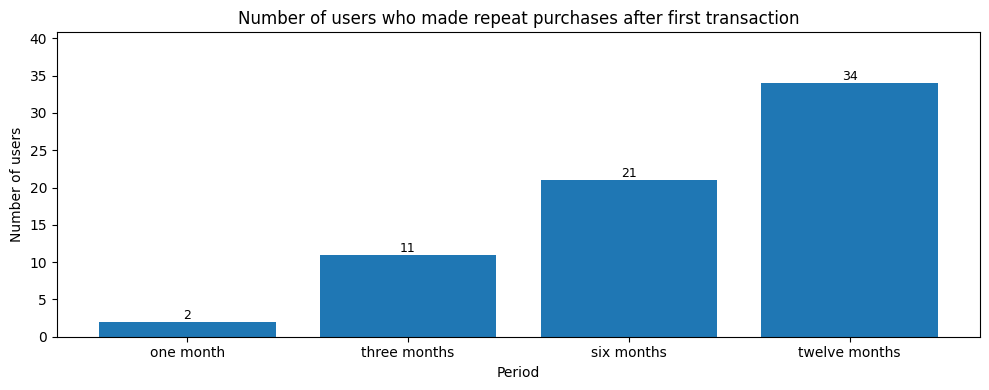

In [49]:
fig, ax = plt.subplots(figsize=(10,4))

bars = ax.bar(
    retention["period"],
    retention["num_cus"]
)

ax.set_title(
    "Number of users who made repeat purchases after first transaction"
)
ax.set_xlabel("Period")
ax.set_ylabel("Number of users")

# 🔥 TĂNG CHIỀU CAO TRỤC Y ĐỂ KHÔNG BỊ CẮT SỐ
y_max = retention["num_cus"].max()
ax.set_ylim(0, y_max * 1.2)

# 🔥 THÊM SỐ LIỆU TRÊN CỘT
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height):,}",   # format có dấu phẩy
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


The number of customer users make purchase again after the first purchase is quite low. We can conclude that users haven't formed the habit of recharging phone account on MoMo. So MoMo need some solutions to encourage users to recharge their phone account on MoMo.

In [50]:
# Dispose of the SQLAlchemy engine to close the connection
engine.dispose()